In [1]:
# HÃ¼cre 1: Gerekli KÃ¼tÃ¼phaneler
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gradio as gr

# TÃ¼rkÃ§e stopwords
turkce_stopwords = set(stopwords.words('turkish'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yrnck\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# HÃ¼cre 2: Temizleme Fonksiyonu
def temizle(yorum):
    yorum = str(yorum).lower()
    yorum = re.sub(r"http\S+", "", yorum)
    yorum = re.sub(r"[^a-zÃ§ÄŸÄ±Ã¶ÅŸÃ¼0-9\s]", "", yorum)
    yorum = re.sub(r"\s+", " ", yorum).strip()
    yorum = " ".join([w for w in yorum.split() if w not in turkce_stopwords])
    return yorum


In [3]:
# HÃ¼cre 3: Veriyi YÃ¼kle ve Temizle
df = pd.read_csv("eticaret-urun-yorumlari.csv", sep=";")
df.columns = ["Metin", "Durum"]
df = df[df["Durum"].isin([0, 1])]
df["temiz_yorum"] = df["Metin"].apply(temizle)
df = df[df['temiz_yorum'].str.len() > 5]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # KarÄ±ÅŸtÄ±r

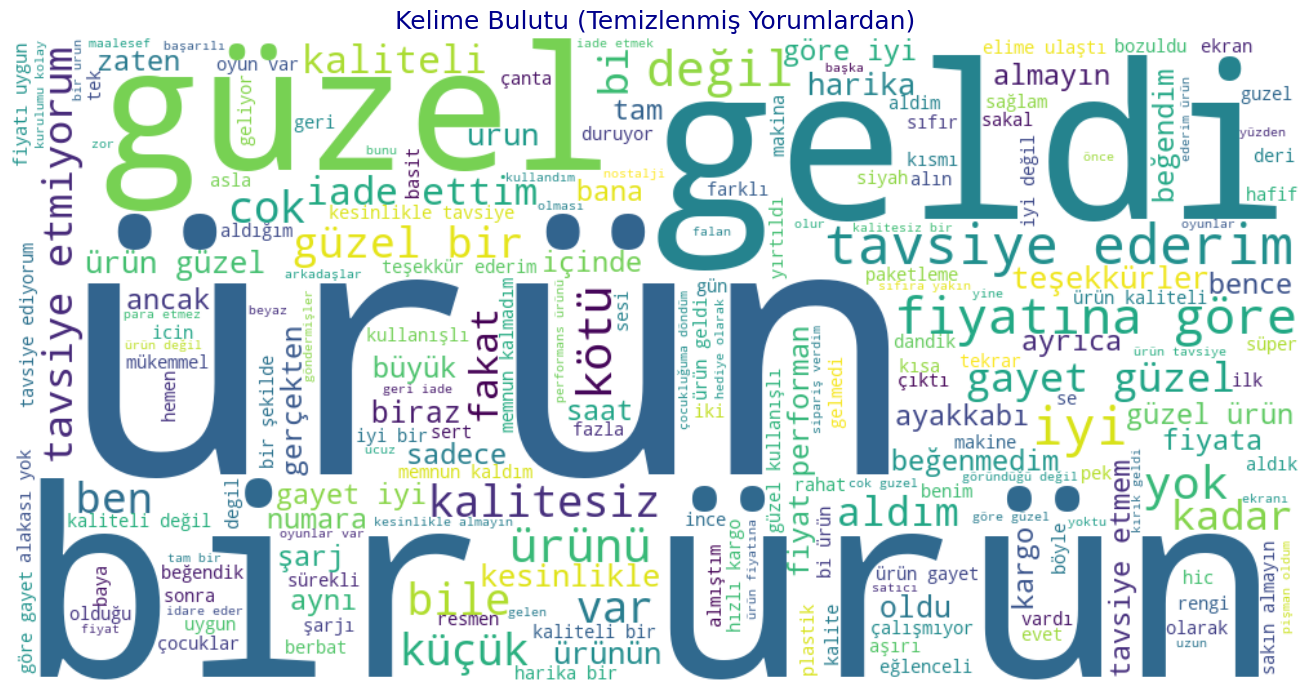

In [4]:
# HÃ¼cre 4: GeliÅŸtirilmiÅŸ WordCloud (Kelime Bulutu)
wc = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis',
    max_words=200,
    contour_color='steelblue',
    contour_width=2
).generate(" ".join(df["temiz_yorum"]))

plt.figure(figsize=(14, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Kelime Bulutu (TemizlenmiÅŸ Yorumlardan)", fontsize=18, color='darkblue')
plt.tight_layout(pad=1)
plt.show()


In [5]:
# HÃ¼cre 5: EÄŸitim/Test AyrÄ±mÄ± (40% test)
X_train, X_test, y_train, y_test = train_test_split(df["temiz_yorum"], df["Durum"], test_size=0.4, random_state=42)


In [6]:
# HÃ¼cre 6: TF-IDF Vectorizer (n-gram, min_df)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  # Yeni model

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [7]:
# HÃ¼cre 7: Multinomial Naive Bayes Modeli ile EÄŸitim
model = MultinomialNB()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print("DoÄŸruluk:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

DoÄŸruluk: 0.9555555555555556
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      2851
           1       0.94      0.97      0.95      2639

    accuracy                           0.96      5490
   macro avg       0.96      0.96      0.96      5490
weighted avg       0.96      0.96      0.96      5490



C:\Users\yrnck\AppData\Local\Temp\ipykernel_3652\1364095197.py:18: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


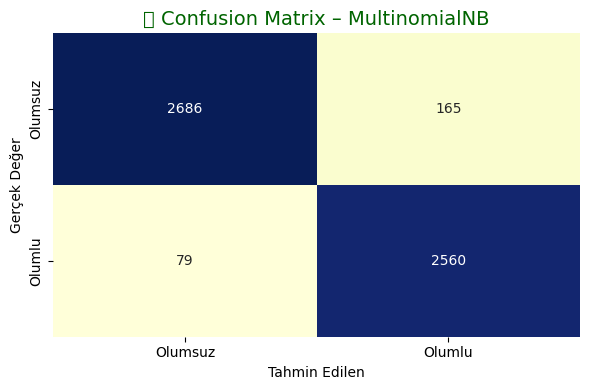

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix hesapla
cm = confusion_matrix(y_test, y_pred)

# Etiketler
etiketler = ["Olumsuz", "Olumlu"]

# Renkli Ä±sÄ± haritasÄ± Ã§iz
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=etiketler, yticklabels=etiketler, cbar=False)

plt.title("ðŸŽ¯ Confusion Matrix â€“ MultinomialNB", fontsize=14, color="darkgreen")
plt.xlabel("Tahmin Edilen")
plt.ylabel("GerÃ§ek DeÄŸer")
plt.tight_layout()
plt.show()


C:\Users\yrnck\AppData\Local\Temp\ipykernel_3652\2044657984.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yrnck\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


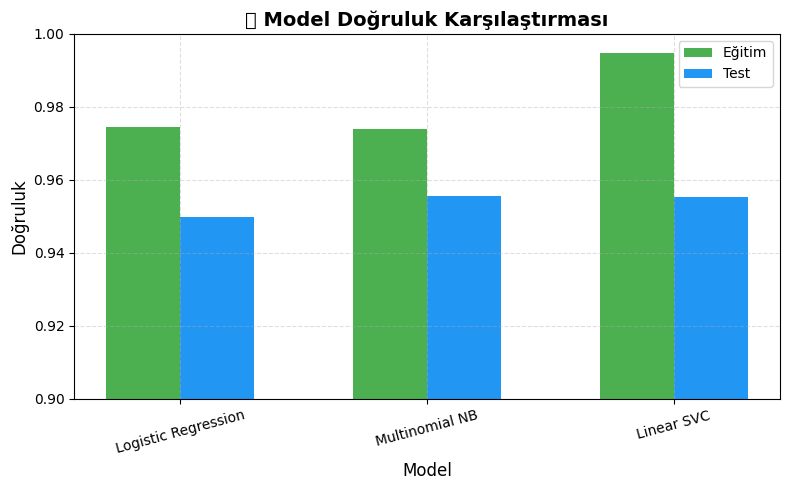

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# KarÅŸÄ±laÅŸtÄ±rma verisi
data = {
    "Model": ["Logistic Regression", "Multinomial NB", "Linear SVC"],
    "EÄŸitim DoÄŸruluÄŸu": [0.9744, 0.9740, 0.9948],
    "Test DoÄŸruluÄŸu": [0.9497, 0.9556, 0.9552]
}

df = pd.DataFrame(data)

# Bar chart Ã§izimi
plt.figure(figsize=(8, 5))
bar_width = 0.3
index = np.arange(len(df))

plt.bar(index, df["EÄŸitim DoÄŸruluÄŸu"], bar_width, label="EÄŸitim", color="#4CAF50")
plt.bar(index + bar_width, df["Test DoÄŸruluÄŸu"], bar_width, label="Test", color="#2196F3")

plt.xlabel("Model", fontsize=12)
plt.ylabel("DoÄŸruluk", fontsize=12)
plt.title("ðŸ“Š Model DoÄŸruluk KarÅŸÄ±laÅŸtÄ±rmasÄ±", fontsize=14, weight="bold")
plt.xticks(index + bar_width / 2, df["Model"], rotation=15)
plt.ylim(0.90, 1.00)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [10]:
def model_karsilastirma_grafigi():
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    data = {
        "Model": ["Logistic Regression", "Multinomial NB", "Linear SVC"],
        "EÄŸitim DoÄŸruluÄŸu": [0.9744, 0.9740, 0.9948],
        "Test DoÄŸruluÄŸu": [0.9497, 0.9556, 0.9552]
    }

    df = pd.DataFrame(data)
    plt.figure(figsize=(8, 5))
    bar_width = 0.3
    index = np.arange(len(df))

    plt.bar(index, df["EÄŸitim DoÄŸruluÄŸu"], bar_width, label="EÄŸitim", color="#4CAF50")
    plt.bar(index + bar_width, df["Test DoÄŸruluÄŸu"], bar_width, label="Test", color="#2196F3")

    plt.xlabel("Model")
    plt.ylabel("DoÄŸruluk")
    plt.title("ðŸ“Š Model DoÄŸruluk KarÅŸÄ±laÅŸtÄ±rmasÄ±")
    plt.xticks(index + bar_width / 2, df["Model"], rotation=15)
    plt.ylim(0.90, 1.00)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return "Grafik baÅŸarÄ±yla Ã§izildi."


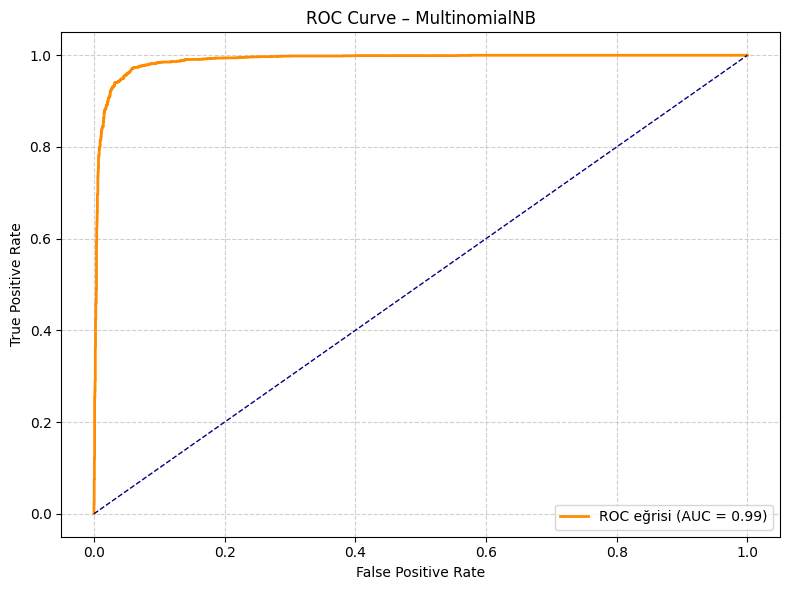

In [11]:
y_probs = model.predict_proba(X_test_vec)[:, 1]  # Olumlu sÄ±nÄ±f olasÄ±lÄ±ÄŸÄ±
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC eÄŸrisi (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve â€“ MultinomialNB")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# EÄŸitilen model
model = LogisticRegression(C=0.5, max_iter=300)
model.fit(X_train_vec, y_train)

# Tahmin
y_pred = model.predict(X_test_vec)

# DoÄŸruluk oranlarÄ±
train_acc = model.score(X_train_vec, y_train)
test_acc = model.score(X_test_vec, y_test)

print(f"EÄŸitim DoÄŸruluÄŸu: %{train_acc*100:.2f}")
print(f"Test DoÄŸruluÄŸu: %{test_acc*100:.2f}")
print("\nSÄ±nÄ±flandÄ±rma Raporu:")
print(classification_report(y_test, y_pred))


In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(C=1.0, max_iter=300),
    "Multinomial NB": MultinomialNB(),
    "Linear SVC": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

print(f"{'Model':<20} | {'Train Acc':<10} | {'Test Acc':<10}")
print("-" * 50)

for name, model_instance in models.items():
    model_instance.fit(X_train_vec, y_train)
    train_acc = model_instance.score(X_train_vec, y_train)
    test_acc = model_instance.score(X_test_vec, y_test)
    print(f"{name:<20} | {train_acc:.4f}    | {test_acc:.4f}")


Model                | Train Acc  | Test Acc  
--------------------------------------------------
Logistic Regression  | 0.9744    | 0.9497
Multinomial NB       | 0.9740    | 0.9556
Linear SVC           | 0.9948    | 0.9552
Random Forest        | 0.9974    | 0.9366


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [16]:
for c in [1.0, 0.5, 0.3, 0.1, 0.05, 0.01]:
    model = LogisticRegression(C=c, max_iter=300)
    model.fit(X_train_vec, y_train)
    
    train_acc = model.score(X_train_vec, y_train)
    test_acc = model.score(X_test_vec, y_test)
    
    print(f"C={c} -> EÄŸitim DoÄŸruluÄŸu: %{train_acc*100:.2f} - Test DoÄŸruluÄŸu: %{test_acc*100:.2f}")


C=1.0 -> EÄŸitim DoÄŸruluÄŸu: %97.44 - Test DoÄŸruluÄŸu: %94.97
C=0.5 -> EÄŸitim DoÄŸruluÄŸu: %96.47 - Test DoÄŸruluÄŸu: %94.64
C=0.3 -> EÄŸitim DoÄŸruluÄŸu: %95.87 - Test DoÄŸruluÄŸu: %93.93
C=0.1 -> EÄŸitim DoÄŸruluÄŸu: %93.76 - Test DoÄŸruluÄŸu: %92.62
C=0.05 -> EÄŸitim DoÄŸruluÄŸu: %92.30 - Test DoÄŸruluÄŸu: %91.60
C=0.01 -> EÄŸitim DoÄŸruluÄŸu: %89.43 - Test DoÄŸruluÄŸu: %89.33


In [17]:
# HÃ¼cre: Multinomial Naive Bayes Modeli ile EÄŸitim
from sklearn.naive_bayes import MultinomialNB

vectorizer_nb = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9)
X_train_vec_nb = vectorizer_nb.fit_transform(X_train)
X_test_vec_nb = vectorizer_nb.transform(X_test)

model_nb = MultinomialNB()
model_nb.fit(X_train_vec_nb, y_train)

y_pred_nb = model_nb.predict(X_test_vec_nb)
print("DoÄŸruluk:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


DoÄŸruluk: 0.9555555555555556
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      2851
           1       0.94      0.97      0.95      2639

    accuracy                           0.96      5490
   macro avg       0.96      0.96      0.96      5490
weighted avg       0.96      0.96      0.96      5490



In [ ]:
# HÃ¼cre: En Etkili Kelimeleri GÃ¶rselleÅŸtir
import numpy as np
import matplotlib.pyplot as plt

log_probs = model_nb.feature_log_prob_
importance = log_probs[1] - log_probs[0]

top_positive_idx = np.argsort(importance)[-15:]
top_negative_idx = np.argsort(importance)[:15]

feature_names = np.array(vectorizer_nb.get_feature_names_out())
top_pos_words = feature_names[top_positive_idx]
top_pos_values = importance[top_positive_idx]
top_neg_words = feature_names[top_negative_idx]
top_neg_values = importance[top_negative_idx]

plt.figure(figsize=(12, 6))
plt.barh(top_pos_words, top_pos_values, color='green', label="Olumlu Etki")
plt.barh(top_neg_words, top_neg_values, color='red', label="Olumsuz Etki")
plt.title("MultinomialNB: Tahmine En Ã‡ok Etki Eden Kelimeler")
plt.xlabel("Etki Skoru (log odds farkÄ±)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(f"Toplam yorum sayÄ±sÄ±: {len(df)}")
print(df['Durum'].value_counts())
